# Lecture IX: High-Performance Python: NumPy, Numba, and Parallel Numba

*LSST DSFP Session 21*

*Instructor: Lehman Garrison (https://github.com/lgarrison)*

**Goals**

In this lecture, we'll:
- discuss why NumPy is faster than Python for array operations,
- identify NumPy temporary array allocations,
- use Numba to speed up certain NumPy computations,
- parallelize Numba calculations,
- identify parallel race conditions.

## Why should we use NumPy?

NumPy is a load-bearing pillar of numerical computing in Python. But why do we use it? After all, Python has `float`, `list`, `for` loops—everything an aspiring numericist needs.

The answer, not surprisingly, is performance. Python is an *interpreted* language—every Python statement is evaluated in a "virtual machine" that implements Python's rules for operations on types. This has many benefits, especially for programmer productivity, but comes with a performance cost.

The "opposite" of an interpreted language is a *compiled* language. Compiled languages transform the source code into machine instructions before execution. The types and operations are figured out before execution. Contrast this with Python, where types and operations are figured out *during* execution.

NumPy is a Python package that calls compiled code (mostly C, C++, and Fortran) to do the heavy lifting. Perhaps the single most important benefit is that array operations become much faster! Let's do a simple test, comparing the amount of time it takes to find the maximum of an array:

In [1]:
import numpy as np

rng = np.random.default_rng(seed=123)

a = rng.permutation(10_000_000)  # 10M random integers

%timeit np.max(a)

5.44 ms ± 13.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2]:
L = list(a)  # convert the NumPy array to a Python list

%timeit max(L)

204 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Besides performance, NumPy comes with many important features, such as array broadcasting, a type system, and numerical algorithms, but for today's lecture we're mostly interested in the performance.

## Why shouldn't we use NumPy?

NumPy is great for *array-oriented* operations. However, sometimes we need to do a computation that is more easily expressed as a *procedural*, or *iterative*, method. Simulations often fall under this umbrella, but also some kinds of analysis.

Let's look at an example: computing the value of $\pi$ via Monte-Carlo simulation. The idea is that if we generate random points in a 2D box, the fraction of points that fall in an inscribed circle is ratio of the circle's area to the square's area. And that ratio is $\pi/4$:

$$
\begin{align*}
\frac{N_{\rm circle}}{N} &= \frac{A_{\rm circle}}{A}, \\
 &= \frac{\pi r^2}{4r^2}, \\
 \end{align*} \\
\pi = \frac{4N_{\rm circle}}{N},
$$

where $N$ is the total number of Monte-Carlo points, and $N_{\rm circle}$ is the number that fall in the inscribed circle.

Let's first illustrate this:

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


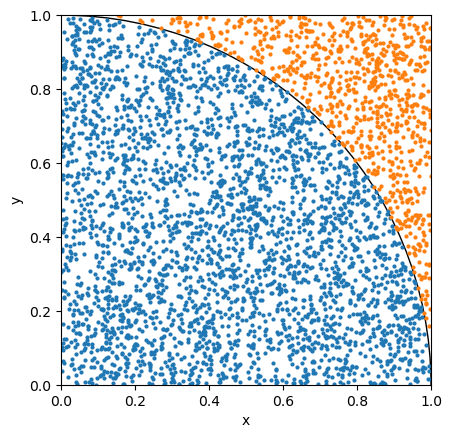

In [3]:
def plot_circle(N=4000):
    import matplotlib.pyplot as plt

    pos = rng.random((2, N))
    in_circle = np.sum(pos**2, axis=0) < 1

    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    circle = plt.Circle((0.0, 0.0), 1.0, fill=False)
    ax.add_artist(circle)

    ax.scatter(*pos[:, in_circle], s=4.0)
    ax.scatter(*pos[:, ~in_circle], s=4.0)

    ax.set_xlabel("x")
    ax.set_ylabel("y")


plot_circle()


Let's write a NumPy function that computes this, taking $N$ as a parameter:

In [4]:
def compute_pi(N, rng=rng):
    pos = rng.random((2, N))
    N_circle = np.sum(np.sum(pos**2, axis=0) < 1)
    return 4 * N_circle / N


%timeit compute_pi(1_000_000)

18.5 ms ± 76.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This works fine, but there's a big downside, and that's memory usage: we had to create a `pos` array of size `2N` 8-byte values. And then squaring that creates *another* temprary array of the same size! Summing the array creates yet another (albeit half the size). The peak memory usage is around 40 GB for `N = 10**9`.

This memory usage comes with two costs:
1) you need enough RAM to hold these temporary arrays in memory, and
2) the computation becomes bottlenecked by the bandwidth to main memory.

From the CPU's perspective, NumPy is doing something really silly. It's generating an `(x,y)` position on the CPU, sending it to main memory, then fetching it back later to square it. Why didn't we just square the value when it was on the CPU, right after it was generated?

This is closely related to the idea of a *CPU cache hierarchy* or *memory heirarchy*, which is usually illustrated as a pyramid ([source](https://cs.brown.edu/courses/csci1310/2020/assign/labs/lab4.html)):

<center>
<img width=60% src=cache.png>
</center>

Faster, smaller memory is at the top, and slower, larger memory is at the bottom. In our example, the random points are generated at the top of the hierarchy and then are stored in the lower levels of the hierarchy, because the arrays are several GB. Wouldn't it be great if we could generate a point and process it without ever leaving the tip of the hierarchy?

## When should we use Numba?

It turns out we can do this with a tool called Numba! Numba is a *just-in-time* (JIT) compiler for Python. It compiles Python functions at the time they are called, since that's when the argument types are known.

Numba lets us rewrite our array-oriented Monte-Carlo computation as an iterative, or loop-oriented, computation. Here's what that looks like:

In [5]:
import numba


@numba.njit
def compute_pi_numba(N, rng):
    N_circle = 0
    for i in range(N):
        x = rng.random()
        y = rng.random()
        if x**2 + y**2 < 1:
            N_circle += 1
    return 4 * N_circle / N


%timeit compute_pi_numba(1_000_000, rng)

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


6.4 ms ± 31 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We got a 3x speedup, which isn't bad. The bottleneck is now probably random number generation.

There are a few special things to note about how we wrote this function.

First, `@numba.njit`: this is a Python *decorator*. Decorators wrap Python functions, potentially transforming them. In this case, the decorator transforms the function by compiling it. `njit` means to JIT-compile in `nopython` mode, which means none of the code is allowed to remain native (un-compiled) Python.

Second, we wrote a `for` loop! After all that talking about how NumPy lets us get rid of Python loops, we've come full circle and are back to writing them. Of course, these loops are JIT-compiled, which makes them fast.

## When we shouldn't use Numba

Numba won't make every Python function faster. In fact, it has to have explicit support for any libraries being used. It works great with NumPy, but in general Python objects won't work well with Numba. For example, you can't pass an Astropy Table to a Numba function:

In [6]:
from astropy.table import Table


@numba.njit
def astropy_numba(t):
    return t["a"].sum()


t = Table({"a": [1, 2, 3]})
astropy_numba(t)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_2749810/3037407176.py (4)[0m
[1m
File "../../../../tmp/ipykernel_2749810/3037407176.py", line 4:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'astropy.table.table.Table'>[0m


However, array containers that are backed by NumPy arrays will generally work fine with Numba. So we can pass a single column of an Astropy table to a Numba function:

In [7]:
@numba.njit
def astropy_numba2(c):
    return c.sum()


t = Table({"a": [1, 2, 3]})
astropy_numba2(t["a"])

6

Numba also may not give a very big speedup without rewriting a function from an array-oriented style to a loop-oriented style. We can see this by taking the original Python version and adding the `@numba.njit` decorator, without doing anything else:

In [8]:
@numba.njit
def compute_pi_numba_array(N, rng):
    pos = rng.random((2, N))
    N_circle = np.sum(np.sum(pos**2, axis=0) < 1)
    return 4 * N_circle / N


%timeit compute_pi_numba_array(1_000_000, rng)

18.8 ms ± 722 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that it's almost the same speed as the original. Sometimes Numba will find a speedup in array-oriented code, but sometimes you have to rewrite the code in a Numba-friendly way to unlock its full potential.

## Parallelism in Numba

We saw Numba helped a lot by avoiding temporary array allocations and alleviating a memory bandwidth bottleneck. But what about if the bottleneck is on the CPU? It turns out Numba can help with that too by parallelizing computations! Let's look at an example.

Consider the following problem: given a set of RA-DEC coordinates, count the number of objects that fall within angle `theta` of a given point (`RA_0`, `DEC_0`).

We'll use Astropy's implementation of the `angular_separation()` function. It's very trig heavy, which indicates that the CPU is likely going to be the bottleneck.

In [9]:
def count_sep(RA_0, DEC_0, lon, lat, theta):
    """Based on Astropy's function for computing the angular separation
    between two points on the sphere.

    License: BSD-3-Clause
    """

    sdlon = np.sin(lon - RA_0)
    cdlon = np.cos(lon - RA_0)
    slat1 = np.sin(DEC_0)
    slat2 = np.sin(lat)
    clat1 = np.cos(DEC_0)
    clat2 = np.cos(lat)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    sep = np.arctan2(np.hypot(num1, num2), denominator)

    return np.sum(sep < theta)

Now we'll make a fake RA-DEC catalog and time this function:

In [10]:
N = 10**7
catalog = Table(
    {
        "RA": np.radians(rng.uniform(0, 180, N)),
        "DEC": np.radians(rng.uniform(-90, 90, N)),
    }
)

RA_0 = catalog["RA"][0]
DEC_0 = catalog["DEC"][0]
theta = np.radians(10.0)
%timeit count_sep(RA_0, DEC_0, catalog['RA'], catalog['DEC'], theta)

1.12 s ± 821 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's write a Numba version and see what kind of speedup we get:

In [11]:
@numba.njit
def count_sep_numba(RA_0, DEC_0, lon, lat, theta):
    N = len(lon)

    count = 0
    for i in range(N):
        sdlon = np.sin(lon[i] - RA_0)
        cdlon = np.cos(lon[i] - RA_0)
        slat1 = np.sin(DEC_0)
        slat2 = np.sin(lat[i])
        clat1 = np.cos(DEC_0)
        clat2 = np.cos(lat[i])

        num1 = clat2 * sdlon
        num2 = clat1 * slat2 - slat1 * clat2 * cdlon
        denominator = slat1 * slat2 + clat1 * clat2 * cdlon

        sep = np.arctan2(np.hypot(num1, num2), denominator)

        if sep < theta:
            count += 1

    return count


%timeit count_sep_numba(RA_0, DEC_0, catalog['RA'], catalog['DEC'], theta)

972 ms ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hmm, that wasn't very impressive. Less than a 50% speedup.

The problem, as alluded to above, is that this computation isn't memory-bandwidth bound. It must be CPU-bound, given all the trig functions!

Numba, like NumPy and Python, only makes use of one CPU core by default. But many laptops have a dozen or more cores these days, and HPC nodes can have over 100!

Fortunately, we can tell Numba to parallelize part of the computation over multiple cores by using `numba.prange()` to replace `range()`. With `numba.prange()`, different CPU threads can execute different loop iterations concurrently. This is a good fit for this function, since the loop iterations do not depend on each other.

The last part is that we have to add a keyword argument to the decorator: `@numba.njit(parallel=True)`.

Let's put this all togther:

In [12]:
@numba.njit(parallel=True)  # <<< this changed
def count_sep_numba_parallel(RA_0, DEC_0, lon, lat, theta):
    N = len(lon)

    count = 0
    for i in numba.prange(N):  # <<< this changed
        sdlon = np.sin(lon[i] - RA_0)
        cdlon = np.cos(lon[i] - RA_0)
        slat1 = np.sin(DEC_0)
        slat2 = np.sin(lat[i])
        clat1 = np.cos(DEC_0)
        clat2 = np.cos(lat[i])

        num1 = clat2 * sdlon
        num2 = clat1 * slat2 - slat1 * clat2 * cdlon
        denominator = slat1 * slat2 + clat1 * clat2 * cdlon

        sep = np.arctan2(np.hypot(num1, num2), denominator)

        if sep < theta:
            count += 1

    return count


%timeit count_sep_numba_parallel(RA_0, DEC_0, catalog['RA'], catalog['DEC'], theta)

69.1 ms ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A 20x speedup! That's more like it!

We need to mention one very magic thing that the Numba parallelization is doing, and that's doing a *reduction* on the `count` variable. Normally, if two threads try to update a shared variable at the same time, a *race condition* occurs. Consider what can happen if two threads try to execute `count += 1` at nearly the same time:

| Time | Thread 1 | Thread 2 | Shared Variable `count` |
|------|----------|----------|------------------------|
| t1   | Reads `count` (value is 0) |          | 0 |
| t2   |          | Reads `count` (value is 0) | 0 |
| t3   | Increments read value by 1 |          | 0 |
| t4   |          | Increments read value by 1 | 0 |
| t5   | Writes incremented value back (value is 1) |          | 1 |
| t6   |          | Writes incremented value back (value is 1) | 1 |

In this example, both threads are trying to increment the shared variable `count`. However, because they read the value of `count` at the same time, they both increment the value from 0 to 1, and then write back the value 1. The final value of `count` is 1, even though it should be 2 if the two increments had been properly synchronized. This is a race condition.

Numba gives each thread its own copy of the `count` variable, and then sums them all at the end. This is called a reduction. Giving each thread its own `count` is also important for performance.

Numba is pretty smart about inferring reductions, but it's not perfect! Always test that your parallelized code gets the same answer as the serial code. You can read more about Numba parallelism and inferred reductions here: https://numba.readthedocs.io/en/stable/user/parallel.html

In [13]:
(
    count_sep(RA_0, DEC_0, catalog["RA"], catalog["DEC"], theta),
    count_sep_numba(RA_0, DEC_0, catalog["RA"], catalog["DEC"], theta),
    count_sep_numba_parallel(RA_0, DEC_0, catalog["RA"], catalog["DEC"], theta),
)

(103974, 103974, 103974)